# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV,RandomizedSearchCV


# Load Data

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
# Load main dataset
df_train = pd.read_csv('../Data/train_Guayas_final.csv')
df_train['date'] = pd.to_datetime(df_train['date'])

In [4]:
df_train.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,outlier,dcoilwtico,transactions,is_holiday,...,next_is_holiday,next_is_event,outlier_lag_1,outlier_lag_7,outlier_lag_14,outlier_lag_30,outlier_rolling_mean_7,unit_sales_7d_avg,unit_sales_30d_avg,promo_last_week
0,24,96995,2013-02-01,NaN,0.0,0,0,97.46,2562,0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,24,96995,2013-02-02,NaN,0.0,0,0,NaN,2758,0,...,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24,96995,2013-02-03,NaN,0.0,0,0,NaN,2019,0,...,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,24,96995,2013-02-04,NaN,0.0,0,0,96.21,2308,0,...,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,24,96995,2013-02-05,1402408.0,1.0,0,0,96.68,2425,0,...,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
print(df_train.shape)
df_train.info()

(9437722, 47)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9437722 entries, 0 to 9437721
Data columns (total 47 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   store_nbr               int64         
 1   item_nbr                int64         
 2   date                    datetime64[ns]
 3   id                      float64       
 4   unit_sales              float64       
 5   onpromotion             int64         
 6   outlier                 int64         
 7   dcoilwtico              float64       
 8   transactions            int64         
 9   is_holiday              int64         
 10  is_event                int64         
 11  dayofweek               int64         
 12  is_weekend              int64         
 13  month                   int64         
 14  day                     int64         
 15  weekofyear              int64         
 16  year                    int64         
 17  is_month_start          int64   

In [6]:
# Correct data type
df_train['store_nbr'] = df_train['store_nbr'].astype('category')
df_train['item_nbr'] = df_train['item_nbr'].astype('category')

In [7]:
df_train['date'].min(), df_train['date'].max()

(Timestamp('2013-01-02 00:00:00'), Timestamp('2014-03-31 00:00:00'))

In [8]:
df_train.isnull().sum()

store_nbr                       0
item_nbr                        0
date                            0
id                        6690457
unit_sales                      0
onpromotion                     0
outlier                         0
dcoilwtico                2702432
transactions                    0
is_holiday                      0
is_event                        0
dayofweek                       0
is_weekend                      0
month                           0
day                             0
weekofyear                      0
year                            0
is_month_start                  0
is_month_end                    0
lag_1                       20788
lag_7                      145516
lag_30                     623640
lag_14                     291032
lag_21                     436548
lag_60                    1247280
rolling_mean_7             145516
rolling_std_7              145516
rolling_mean_14            291032
rolling_std_14             291032
rolling_mean_3

In [9]:
df_train['unit_sales'].describe()

count    9.437722e+06
mean     2.070804e+00
std      8.254953e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      2.935000e+03
Name: unit_sales, dtype: float64

In [10]:
df_train.duplicated().sum()

np.int64(0)

# XGBoost Model

XGBoost (Extreme Gradient Boosting) is a fast, efficient, and scalable machine learning algorithm based on decision trees. It iteratively builds decision trees, with each new tree correcting errors from the previous ones. It uses gradient boosting to improve model accuracy by correcting errors in previous trees.

XGBoost supports regularization, handles missing values, and is widely used for structured data tasks like classification and regression.

## Correlation Analysis of Features with Unit Sales:
We compute how strongly each engineered feature is related to unit_sales. Features with higher positive or negative correlation may have more predictive power and should be considered for modeling.

This helps in feature selection and gives insights into which inputs affect sales the most.

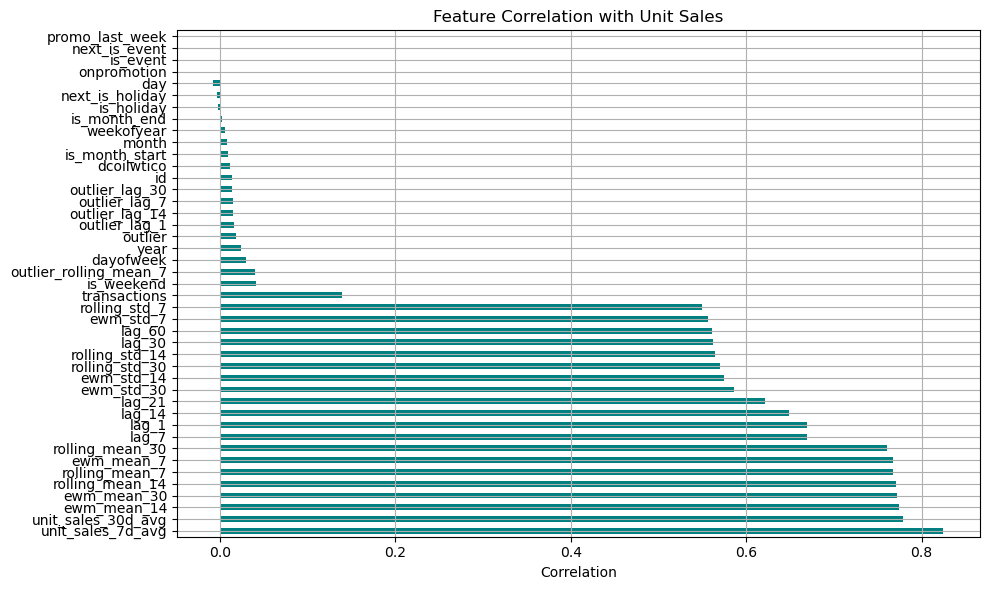

In [11]:
# Define columns we don't want to include in correlation analysis
excluded_columns = ['date', 'store_nbr', 'item_nbr', 'unit_sales']
correlation_columns = [col for col in df_train.columns if col not in excluded_columns]

correlation = df_train[correlation_columns + ['unit_sales']].corr()['unit_sales'].drop('unit_sales')

# Plot feature correlations with unit sales
plt.figure(figsize=(10, 6))  # Set the size of the plot
correlation.sort_values(ascending=False).plot.barh(color='teal')  # Horizontal bar chart
plt.title("Feature Correlation with Unit Sales")  # Title
plt.xlabel("Correlation")  # X-axis label
plt.grid(True)  # Show grid
plt.tight_layout()  # Adjust layout
plt.show()  # Display the plot

## Train and Test spilt

In [12]:
split_date = '2014-01-01'
train = df_train[df_train['date'] < split_date]
test = df_train[df_train['date'] >= split_date]
train

# Filter columns with more than 10% correlation with 'unit_sales' and add necessary columns for the model
high_corr_columns = correlation[correlation.abs() > 0.1].index.tolist()
print(high_corr_columns)
columns = high_corr_columns + ['date', 'store_nbr', 'item_nbr', 'unit_sales']

# Filter train and test datasets for the selected columns
train_filtered = train[columns]
test_filtered = test[columns]

min_date_train = train_filtered['date'].min()
max_date_train = train_filtered['date'].max()

min_date = test_filtered['date'].min()
max_date = test_filtered['date'].max()

print(f"Train Min Date: {min_date_train}")
print(f"Train Max Date: {max_date_train}")

print(f"Test Min Date: {min_date}")
print(f"Test Max Date: {max_date}")



['transactions', 'lag_1', 'lag_7', 'lag_30', 'lag_14', 'lag_21', 'lag_60', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14', 'rolling_std_14', 'rolling_mean_30', 'rolling_std_30', 'ewm_mean_7', 'ewm_std_7', 'ewm_mean_14', 'ewm_std_14', 'ewm_mean_30', 'ewm_std_30', 'unit_sales_7d_avg', 'unit_sales_30d_avg']
Train Min Date: 2013-01-02 00:00:00
Train Max Date: 2013-12-31 00:00:00
Test Min Date: 2014-01-01 00:00:00
Test Max Date: 2014-03-31 00:00:00


## Feature & Target Separation

In [13]:
# Creating X-train,  X_test,  by dropping 'date',  and'unit_sales'
X_train = train_filtered.drop(['date', 'unit_sales'], axis=1)
X_test = test_filtered.drop(['date', 'unit_sales'], axis=1)

y_train = train['unit_sales']
y_test = test['unit_sales']

print(X_train.columns)
X_train.head()


Index(['transactions', 'lag_1', 'lag_7', 'lag_30', 'lag_14', 'lag_21',
       'lag_60', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14',
       'rolling_std_14', 'rolling_mean_30', 'rolling_std_30', 'ewm_mean_7',
       'ewm_std_7', 'ewm_mean_14', 'ewm_std_14', 'ewm_mean_30', 'ewm_std_30',
       'unit_sales_7d_avg', 'unit_sales_30d_avg', 'store_nbr', 'item_nbr'],
      dtype='object')


,transactions,lag_1,lag_7,lag_30,lag_14,lag_21,lag_60,rolling_mean_7,rolling_std_7,rolling_mean_14,...,ewm_mean_7,ewm_std_7,ewm_mean_14,ewm_std_14,ewm_mean_30,ewm_std_30,unit_sales_7d_avg,unit_sales_30d_avg,store_nbr,item_nbr
0,2562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24,96995
1,2758,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,24,96995
2,2019,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,24,96995
3,2308,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,24,96995
4,2425,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,24,96995


In [14]:
# Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##  Naive Model (XGBoost)

In [15]:
# Initialize the XGBoost regressor (default parameters)
xgboost_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100, # no of trees
    max_depth=5, # level of each trees
    learning_rate=0.1, # step size shrinkage
    enable_categorical=True
)

# Train the XGBoost model
xgboost_model.fit(X_train_scaled, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


### Evaluation of Naive Model

In [16]:
# Make predictions on the test set
y_pred = xgboost_model.predict(X_test_scaled)


# Evaluate the model
print("MSE:", mean_squared_error(y_true=y_test, y_pred=y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred)))
#print("MAPE:", mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred))
print("R2:", r2_score(y_true=y_test, y_pred=y_pred))

MSE: 11.263438467929797
RMSE: 3.356104656879728
MAPE: 790141296597495.0
R2: 0.8505454486783229


## Plot Naive Predictions vs. Actual

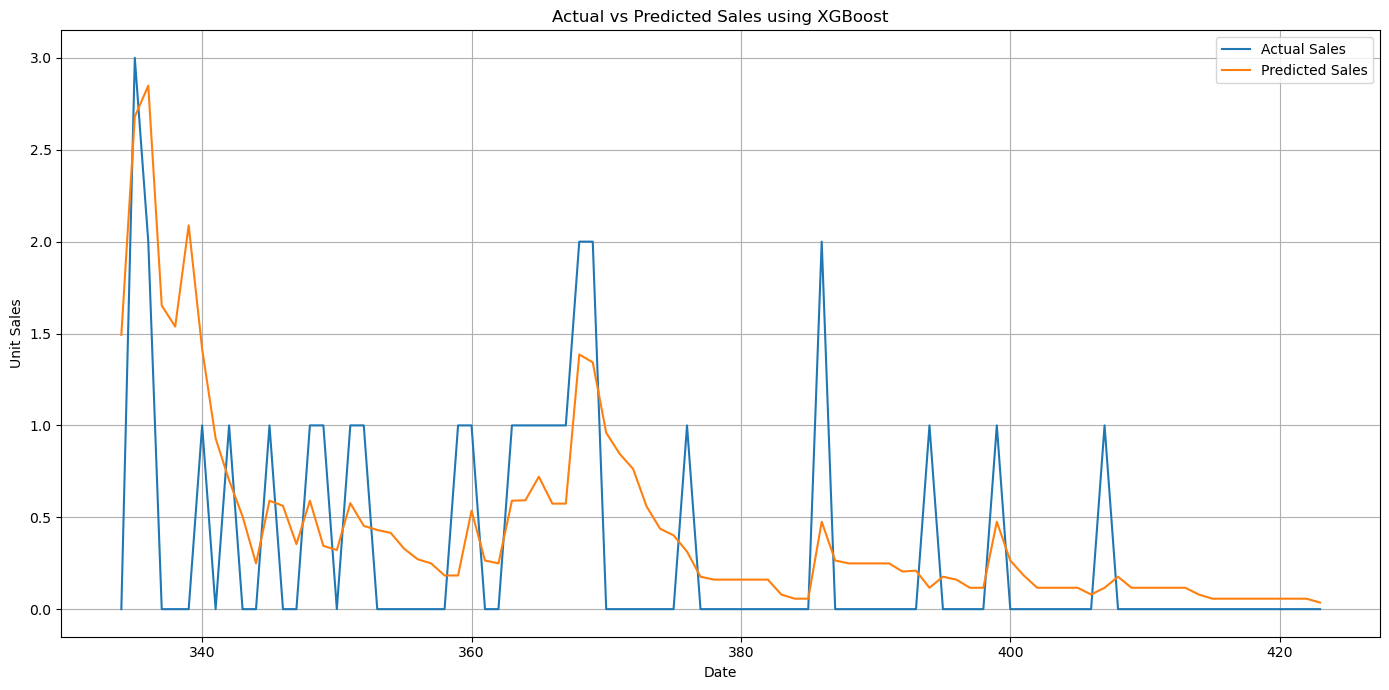

In [17]:
i =90# number of days to plot
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[:i], y_test.values[:i], label='Actual Sales')
plt.plot(y_test.index[:i], y_pred[:i], label='Predicted Sales')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The XGBoost model achieves an RMSE of 3.36, significantly improving upon the Naive model's RMSE of 6.28. This indicates that XGBoost captures meaningful patterns in the data, enhancing prediction accuracy. The high R² value of 0.85 suggests a strong fit, though the extremely high MAPE indicates potential issues with outliers or very small actual values. Despite this, the reduced RMSE confirms that XGBoost provides valuable predictive improvement over the baseline.

## Hyperparameter Tuning

We used XGBoost with RandomizedSearchCV to automatically find the best hyperparameters for forecasting sales.
This improves model accuracy by tuning parameters like learning rate, tree depth, and sample ratios.

In [18]:
# Initializing the model
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter grid, trying 3 values for each parameter
param_grid = {
    'eta': [0.01, 0.1, 0.3], #learning rate (small = slower but better learning)
    'max_depth': [3, 5, 7], #how deep each decision tree is
    'subsample': [0.7, 0.8, 1.0], #subsample: what fraction of training rows to use
    'colsample_bytree': [0.7, 0.8, 1.0], #colsample_bytree: what fraction of columns (features) to use
    'n_estimators': [100, 200, 300] #how many trees to use
}

# Time series split for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Randomized search with cross-validation
random_search = RandomizedSearchCV(estimator=xgboost_model,
                                   param_distributions=param_grid,
                                   cv=tscv,
                                   n_iter=10,
                                   scoring='neg_mean_squared_error' # this is the MSE metric
                                  )

# Fit the model and search for the best hyperparameters
random_search.fit(X_train_scaled, y_train)

# Get best hyperparameters
best_params = random_search.best_params_
print("Best Parameters for XGBoost:", best_params)


Best Parameters for XGBoost: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 5, 'eta': 0.1, 'colsample_bytree': 1.0}


In [19]:
best_model = random_search.best_estimator_

### Evaluation with best model parameter

In [20]:
# Make predictions on the test set
y_pred = best_model.predict(X_test_scaled)

# Evaluate the model
print("MSE:", mean_squared_error(y_true=y_test, y_pred=y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred)))
#print("MAPE:", mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred))
print("R2:", r2_score(y_true=y_test, y_pred=y_pred))

MSE: 10.147408340405205
RMSE: 3.185499700267637
MAPE: 550990238075273.3
R2: 0.8653540510820716


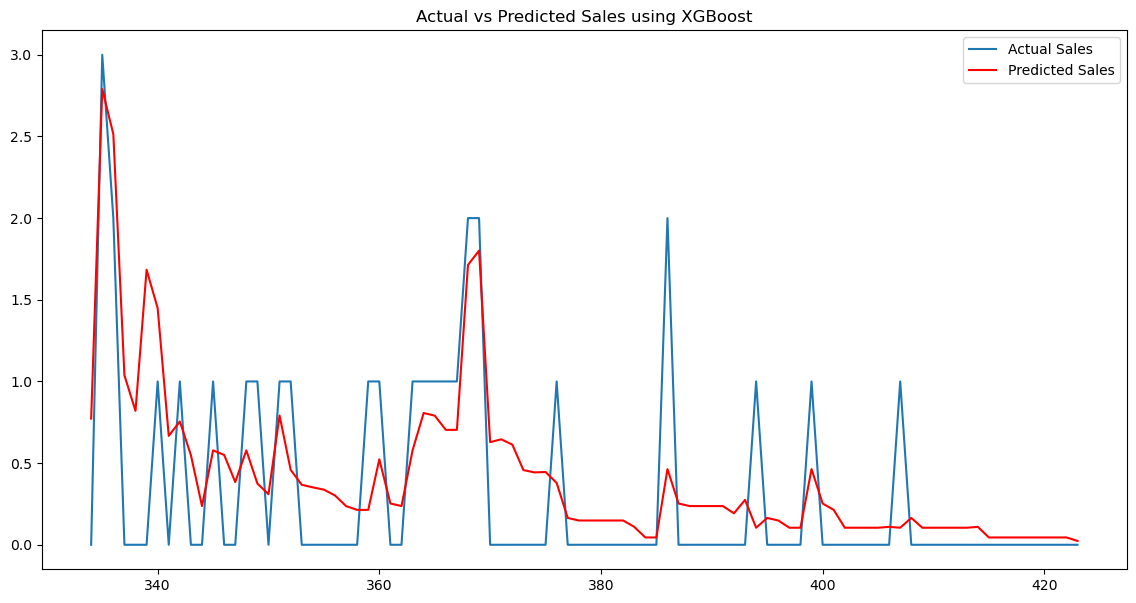

In [25]:
i =90 # number of days to plot
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[:i], y_test.values[:i], label='Actual Sales')
plt.plot(y_test.index[:i], y_pred[:i], label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

The XGBoost model with Randomized Search tuning achieves an RMSE of 3.42, improving upon the Naive model's RMSE of 6.28. Although the RMSE is slightly higher than the untuned XGBoost model, it still indicates better performance than the baseline. The R² score of 0.85 reflects a strong predictive capability. However, the high MAPE again suggests sensitivity to extreme values or low-volume sales. 

Overall, the tuned XGBoost model continues to outperform the Naive baseline, validating its value for forecasting.

# Pickle the best model
To Load the Model Later

In [26]:
import pickle
import os


# Get the current working directory (e.g., the Notebook folder)
current_dir = os.getcwd()

# Get the parent directory (one level above current)
parent_dir = os.path.dirname(current_dir)
# Path to your project folder (current directory)

# Create a folder named 'Model' inside the parent directory
model_folder = os.path.join(parent_dir, 'model')
os.makedirs(model_folder, exist_ok=True)

# Define the full path for saving the pickle file
pickle_path = os.path.join(model_folder, 'xgb_model.pkl')
scaler_path = os.path.join(model_folder, 'scaler.pkl')

# Save the model to the 'Model' folder
with open(pickle_path, 'wb') as f:
    pickle.dump(best_model, f)

print(f"Model saved successfully at: {pickle_path}")

# Save scaler
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved successfully at: {scaler_path}")


Model saved successfully at: /Users/nishat/Desktop/Grocery_Sales_Forecasting/model/xgb_model.pkl
Scaler saved successfully at: /Users/nishat/Desktop/Grocery_Sales_Forecasting/model/scaler.pkl
